<a href="https://colab.research.google.com/github/Adrianav0510/DeltaNews/blob/main/DeltaNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIENVENIDO A DELTA NEWS
¡una brújula en el laberinto de opiniones y noticias!



## PREAMBULO


---


Primero ejecute estas celdas para el correcto funcionamiento del codigo.

Para ejecutar, tan solo haga click en el botón de simbolo "play".

### BIBLIOTECAS PARA LA EJECUCIÓN

In [ ]:
%%capture
#WEB SCRAPING
!pip install nltk
!pip install newspaper3k

#ANALISIS DE SENTIMIENTOS
#TRADUCTOR
!pip install translate
!pip install googletrans==3.1.0a0

#ANALISIS DE SENTIMIENTOS
!pip install textblob

import pandas as pd
import nltk
from newspaper import Article
from googletrans import Translator
from textblob import TextBlob

#VISUALIZACIONES
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

### FUNCIONES PARA LA EJECUCIÓN

In [ ]:
#FUNCION PRINCIPAL PARA EL ANALISIS
def analizar_noticias_con_input():
  """
  Analiza una lista de URLs de noticias, extrayendo información, limpiando texto,
  realizando análisis de sentimiento, categorizando los resultados e
  identificando la ciudad más mencionada en cada noticia.
  Las URLs son obtenidas del usuario.

  Returns:
    Un DataFrame de Pandas con los resultados del análisis.
  """
  urls = []
  while True:
    url = input("Ingrese una URL (o escriba 'fin' para terminar): ")
    if url.lower() == 'fin':
      break
    urls.append(url)

  #INICIALIZAMOS NUESTROS CONTENEDORES PARA EL DF
  text=[]
  publisg_date=[]
  title=[]
  authors=[]
  summary = []

  #DESCARGAMOS NUESTROS ARTICULOS Y ALMACENAMOS SUS PARTES
  for url in urls:
    article= Article(url)
    article.download()
    article.parse()
    nltk.download('punkt')
    article.nlp()
    title.append(article.title)
    authors.append(article.authors)
    publisg_date.append(article.publish_date)
    summary.append(article.summary)
    text.append(article.text)

  #CREAMOS EL DATAFRAME
  dic_df = {
      'title': title,
      'authors': authors,
      'publisg_date': publisg_date,
      'summary': summary,
      'text': text
  }
  df = pd.DataFrame(dic_df)

  #LIMPIAMOS LOS DATOS, ES NEECESARIO HACERLO EN ESPAÑOL, CONSIDERANDO LOS SIGNOS DE PUNNTUACIÓN
  nltk.download('stopwords')
  stop_words_es = set(stopwords.words('spanish'))

  #NUESTRA FUNCIÓN DE LIMPIEZA
  def clean_text(text):
    text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ ]+', '', text)
    text = text.lower()
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words_es]
    return ' '.join(cleaned_words)

  #APLICAMOS CLEAN_TEXT
  df['title_clean'] = df['title'].apply(clean_text)
  df['text_clean'] = df['text'].apply(clean_text)

  #PAARA ANALIZAR LOS SENTIMIENTOS, ES NECESARIO TRADUCIR AL INGLES
  #EN EL FUTURO PODEMOS APLICAR UNA VARIEDAD DE MODELOS DE MACHINE LEARNING PARA LOS FINES ESPECIFICOS DE NUESTRO PROYECTO
  #DE TODOS LOS MODELOS DE ML, ELEGIREMOS EL MÁS PRECISO.
  translator = Translator()

  def analyze_sentiment(text):
    translation = translator.translate(text, dest='en')
    blob = TextBlob(translation.text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

  #APLICAMOS LA FUNCIÓN DE ANALISIS DE SENTIMIENTOS
  df['title_sentiment'], df['title_subjectivity'] = zip(*df['title_clean'].apply(analyze_sentiment))
  df['text_sentiment'], df['text_subjectivity'] = zip(*df['text_clean'].apply(analyze_sentiment))

  #AQUI CATEGORIZAMOS LOS SENTIMIENTOS EN POSITIVO, NEGATIVO O NEUTRAL.
  def categorize_sentiment(sentiment_score):
    if sentiment_score > 0:
      return 'positivo'
    elif sentiment_score < 0:
      return 'negativo'
    else:
      return 'neutral'

  df['sentiment_category_title'] = df['title_sentiment'].apply(categorize_sentiment)
  df['sentiment_category_text'] = df['text_sentiment'].apply(categorize_sentiment)

  #POR ULTIMO, CATEGORIZAMOS LA SUBJETIVIDAD.
  def categorize_subjectivity(subjectivity_score):
    if subjectivity_score >= 0.5:
      return 'subjetiva'
    else:
      return 'objetiva'

  df['subjectivity_category_title'] = df['title_subjectivity'].apply(categorize_subjectivity)
  df['subjectivity_category_text'] = df['text_subjectivity'].apply(categorize_subjectivity)

  #IDENTIFICAR CIUDAD MÁS MENCIONADA
  ciudades_principales = [
    "Bogotá",
    "Medellín",
    "Cali",
    "Barranquilla",
    "Cartagena",
    "Cúcuta",
    "Bucaramanga",
    "Pereira",
    "Santa Marta",
    "Ibagué",
    "Manizales",
    "Neiva",
    "Villavicencio",
    "Pasto",
    "Armenia",
    "Valledupar",
    "Montería",
    "Popayán",
    "Sincelejo",
    "Riohacha",
    "Tunja",
    "Florencia"
  ]

  def count_city_mentions(text, cities):
    city_counts = {}
    text_lower = text.lower()
    for city in cities:
      city_lower = city.lower()
      city_counts[city] = text_lower.count(city_lower)
    return city_counts

  def most_mentioned_city(city_mentions):
    if not city_mentions:
      return None
    most_mentioned = max(city_mentions, key=city_mentions.get)
    return most_mentioned

  most_mentioned_cities = []
  for text in df['text']:
    city_counts = count_city_mentions(text, ciudades_principales)
    most_mentioned = most_mentioned_city(city_counts)
    most_mentioned_cities.append(most_mentioned)

  df['ciudad_mas_mencionada'] = most_mentioned_cities

  return df



In [ ]:
def generar_graficos_torta(df):
  """
  Genera cuatro gráficos de torta que muestran la distribución de la subjetividad
  y los sentimientos tanto en los títulos como en el texto de las noticias.

  Args:
    df: Un DataFrame de Pandas con los resultados del análisis de noticias.

  Returns:
    None. Muestra los gráficos directamente.
  """
  #GRACIAS HACKATHON POR HACERME CONOCER ESTE ESTILO PRECIOSO
  plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

  #TITULOS
  #SUBJETIVIDAD:
  category_counts_sub_title = df.groupby(['subjectivity_category_title'])['subjectivity_category_title'].count()
  counts_sub_title = pd.DataFrame(category_counts_sub_title).rename(columns={"subjectivity_category_title": "Counts"})

  #SENTIMIENTO:
  category_counts_sent_title = df.groupby(['sentiment_category_title'])['sentiment_category_title'].count()
  counts_sent_title = pd.DataFrame(category_counts_sent_title).rename(columns={"sentiment_category_title": "Counts"})

  #TEXTO - NOTICIA
  #SUBJETIVIDAD:
  category_counts_sub_text = df.groupby(['subjectivity_category_text'])['subjectivity_category_text'].count()
  counts_sub_text = pd.DataFrame(category_counts_sub_text).rename(columns={"subjectivity_category_text": "Counts"})

  #SENTIMIENTO:
  category_counts_sent_text = df.groupby(['sentiment_category_text'])['sentiment_category_text'].count()
  counts_sent_text = pd.DataFrame(category_counts_sent_text).rename(columns={"sentiment_category_text": "Counts"})

  #CREAR LOS SUBPLOTS
  fig, axes = plt.subplots(2, 2, figsize=(10, 8))

  #GRAFICO 1 - SUBJETIVIDAD DE LOS TITULOS
  axes[0, 0].pie(counts_sub_title['Counts'], labels=counts_sub_title.index, autopct='%1.1f%%', startangle=90)
  axes[0, 0].axis('equal')
  axes[0, 0].set_title('Subjetividad de Títulos')

  #GRAFICO 2 - SENTIMIENTO DE LOS TITULOS
  axes[0, 1].pie(counts_sent_title['Counts'], labels=counts_sent_title.index, autopct='%1.1f%%', startangle=90)
  axes[0, 1].axis('equal')
  axes[0, 1].set_title('Sentimiento de Títulos')

  #GRAFICO 3 - SUBJETIVIDAD DEL TEXTO - NOTICIA
  axes[1, 0].pie(counts_sub_text['Counts'], labels=counts_sub_text.index, autopct='%1.1f%%', startangle=90)
  axes[1, 0].axis('equal')
  axes[1, 0].set_title('Subjetividad de Texto')

  #GRAFICO 4 - SENTIMIENTO DEL TEXTO NOTICIA
  axes[1, 1].pie(counts_sent_text['Counts'], labels=counts_sent_text.index, autopct='%1.1f%%', startangle=90)
  axes[1, 1].axis('equal')
  axes[1, 1].set_title('Sentimiento de Texto')

  plt.tight_layout()
  plt.show()

In [ ]:
def generar_mapa_calor_correlacion(df):
  """
  Genera un mapa de calor que muestra la correlación entre las variables
  de sentimiento y subjetividad en los títulos y el texto de las noticias.

  Args:
    df: Un DataFrame de Pandas con los resultados del análisis de noticias.

  Returns:
    Un objeto matplotlib.axes.Axes que representa el mapa de calor.
  """

  # PARA EL HEATMAP, ES NECESARIO LA MATRIZ DE CORRELACIÓN
  correlation_matrix = df[['title_sentiment', 'title_subjectivity', 'text_sentiment', "text_subjectivity"]].corr()

  #CREAMOS EL HEATMAP
  plt.figure(figsize=(10, 8))
  ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
  plt.title('Correlation Heatmap')
  return ax

In [ ]:
def generar_nubes_palabras(df):
  """
  Genera dos nubes de palabras, una para los títulos y otra para el texto de las noticias.

  Args:
    df: Un DataFrame de Pandas con los resultados del análisis de noticias.

  Returns:
    Una tupla de dos objetos WordCloud, el primero para los títulos y el segundo para el texto.
  """
  #NO BORRAR
  nltk.download('stopwords')
  stop_words_es = set(stopwords.words('spanish'))

  #WORDCLOUD PARA TITULARES
  text_titulos = " ".join(title for title in df.title_clean)
  wordcloud_titulos = WordCloud(width=800, height=800,
                                background_color='black',
                                stopwords=stop_words_es,
                                min_font_size=10).generate(text_titulos)

  #WORLDCLOUD PARA LAS NOTICIAS
  text_texto = " ".join(texto for texto in df.text_clean)
  wordcloud_texto = WordCloud(width=800, height=800,
                               background_color='black',
                               stopwords=stop_words_es,
                               min_font_size=10).generate(text_texto)

  return wordcloud_titulos, wordcloud_texto


## WEB SCRAPPING Y ANALISIS DE LA NOTICIA


---



Visualice y ejecute la celda, despues introduzca los links de las noticias.

Mientras más noticias ingrese, mejores y más confiables seran las visualizaciones.


In [ ]:

df_resultados = analizar_noticias_con_input()

for index, row in df_resultados.iterrows():
  print(f"Titular: {row['title']}")
  print(f"Sentimiento del titular: {row['sentiment_category_title']}")
  print(f"Subjetividad del titular: {row['subjectivity_category_title']}")
  print(f"Sentimiento de la noticia: {row['sentiment_category_text']}")
  print(f"Subjetividad de la noticia: {row['subjectivity_category_text']}")
  print(f"Ciudad de la noticia: {row['ciudad_mas_mencionada']}")
  print("-" * 30)


Ingrese una URL (o escriba 'fin' para terminar): https://elpais.com/america/2024-07-20/venezuela-experimenta-una-recuperacion-economica-en-tiempos-de-incertidumbre-electoral.html
Ingrese una URL (o escriba 'fin' para terminar): fin
Titular: Venezuela experimenta una recuperación económica en tiempos de incertidumbre electoral
Sentimiento del titular: positivo
Subjetividad del titular: objetiva
Sentimiento de la noticia: positivo
Subjetividad de la noticia: objetiva
Ciudad de la noticia: Cali
------------------------------


## VISUALIZACIONES


---


Una imagen vale más que mil palabras.

Observe el analisis gracias a las funciones de visualización

La siguiente celda crea un gráfico de torta a partir de las noticias analizadas:

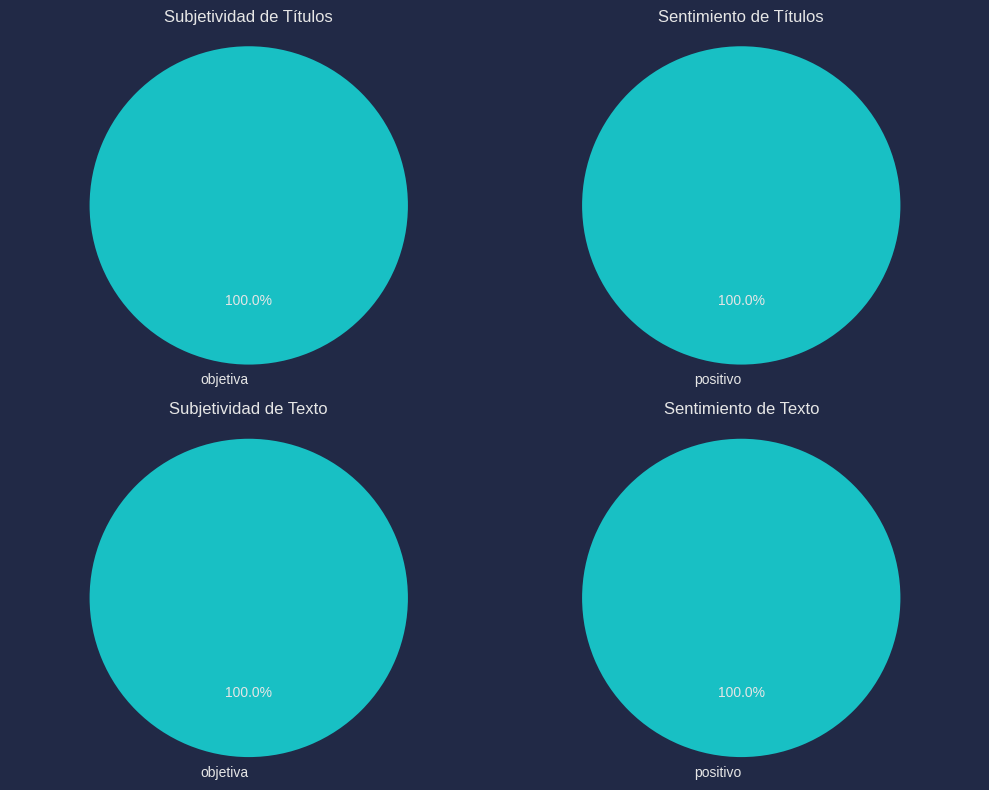

In [ ]:
#GRAFICO DE TORTA
generar_graficos_torta(df_resultados)

La siguiente celda crea un heatmap - grafico de calor - que permite visualizar la relacion del analisis de la noticia:

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


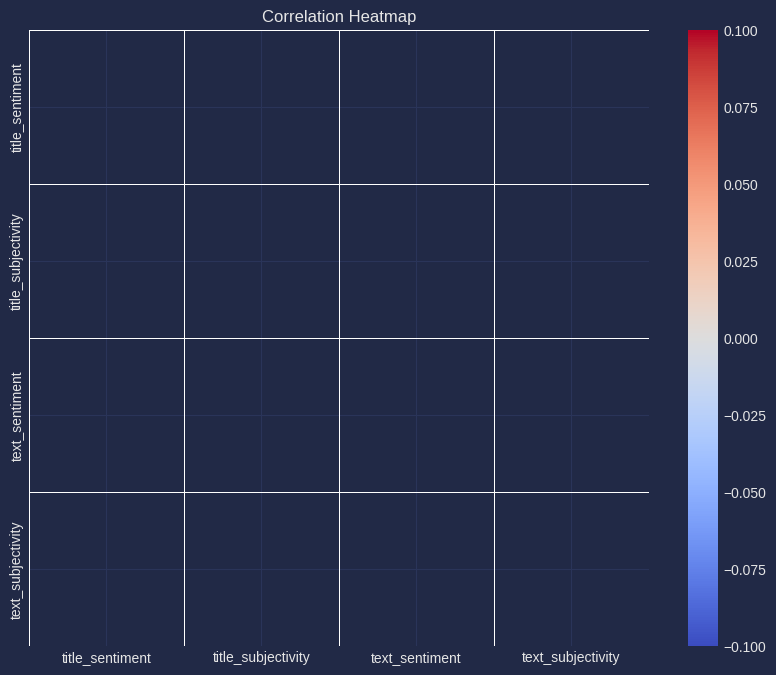

In [ ]:
#HEATMAP - Grafico de Calor
ax = generar_mapa_calor_correlacion(df_resultados)
plt.show()

La siguiente celda crea un WordCloud - nube de palabras - que permite visualizar la narrativa del conjunto de noticias:

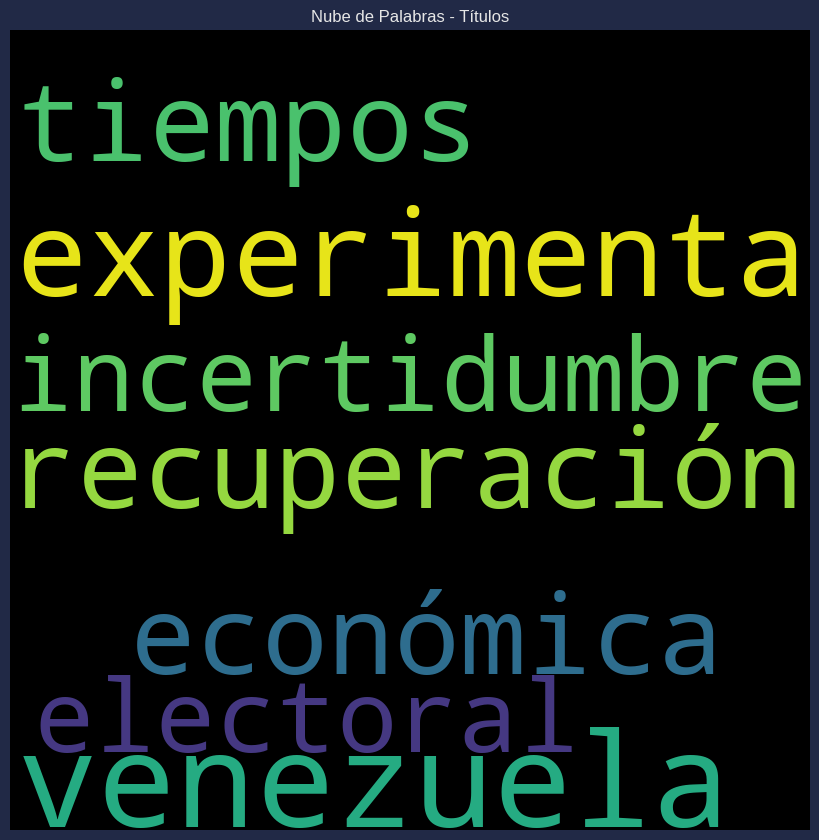

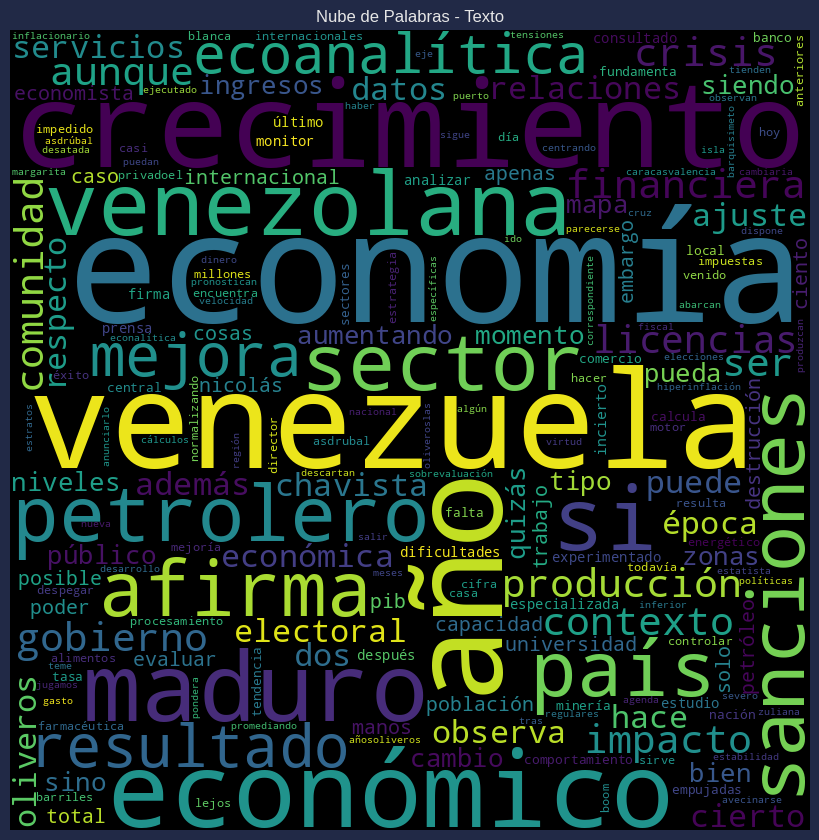

In [ ]:

#EJEMPLO DE USO - NO BORRAR
wordcloud_titulos, wordcloud_texto = generar_nubes_palabras(df_resultados)

#ESTO ES NECESARIO PARA MOSTRAR AMBOS A LA VEZ.
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_titulos)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Nube de Palabras - Títulos")
plt.show()

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_texto)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Nube de Palabras - Texto")
plt.show()

## Dataframe con los datos

En la siguiente linea puede visualizar el df producto del analisis.

In [ ]:
df_resultados

,title,authors,publisg_date,summary,text,title_clean,text_clean,title_sentiment,title_subjectivity,text_sentiment,text_subjectivity,sentiment_category_title,sentiment_category_text,subjectivity_category_title,subjectivity_category_text,ciudad_mas_mencionada
0,Venezuela experimenta una recuperación económi...,[Alonso Moleiro],2024-07-20,"Venezuela, en este año electoral de resultado ...","Venezuela, en este año electoral de resultado ...",venezuela experimenta recuperación económica t...,venezuela año electoral resultado incierto exp...,0.2,0.2,0.063962,0.339204,positivo,positivo,objetiva,objetiva,Cali
